# Qiskit addon utilities

The Qiskit addon utilities package is a collection of functionalities to supplement workflows involving one or more Qiskit addons. For example, this package contains functions for creating Hamiltonians, generating Trotter time-evolution circuits, and slicing and combining quantum circuits.

## Installation

There are two ways to install the Qiskit addon utilities: PyPI and building from source. It is recommended to install these packages in a [virtual environment](https://docs.python.org/3.10/tutorial/venv.html) to ensure separation between package dependencies.

### Install from PyPI

The most straightforward way to install the Qiskit addon utilities package is via PyPI.

```bash
pip install 'qiskit-addon-aqc-utils'
```

### Install from source

<details>
<summary>
Click here to read how to install this package manually.
</summary>

If you wish to contribute to this package or want to install it manually, first clone the repository:

```bash
git clone git@github.com:Qiskit/qiskit-addon-utils.git
```

and install the package via `pip`. If you plan to run the tutorials found in the package repository, install the notebook dependencies as well. If you plan to develop in the repository, install the `dev` dependencies.
```bash
pip install tox jupyterlab -e '.[notebook-dependencies,dev]'
```
</details>

## Get started with utilities

There are several modules within the `qiskit-addon-utils` package, including one for problem generation for simulating quantum systems, graph coloring to more efficiently place gates in a quantum circuit, and circuit slicing, which can help with [operator backpropagation](/guides/qiskit-addons-obp). The following sections summarize each module. The package's [API documentation](/api/qiskit-addon-utils/index) also contains helpful information.

### Problem generation

The contents of the [`qiskit_addon_utils.problem_generators`](../api/qiskit-addon-utils/problem-generators) module include:

- A [`generate_xyz_hamiltonian()`](../api/qiskit-addon-utils/problem-generators#generate_xyz_hamiltonian) function, which generates a connectivity-aware `SparsePauliOp` representation of an Ising-type XYZ model:

$$H = \sum_{(j,k)\in E} \left(J_x X_jX_k + J_yY_jY_k + J_zZ_jZ_k\right) + \sum_{j\in V} \left(h_x X_j + h_y Y_j + h_z Z_j\right) $$
- A [`generate_time_evolution_circuit()`](../api/qiskit-addon-utils/problem-generators#generate_time_evolution_circuit) function, which constructs a circuit modeling the time evolution of a given operator.
- Three different [`PauliOrderStrategy`s](../api/qiskit-addon-utils/problem-generators#pauliorderstrategy) for enumerating between different Pauli string orderings. This is mostly helpful when used alongside graph coloring and can be used as arguments in both the `generate_xyz_hamiltonian()` and `generate_time_evolution_circuit()` functions.



### Graph coloring

The [`qiskit_addon_utils.coloring`](../api/qiskit-addon-utils/coloring) module is used to color the edges in a coupling map and use this coloring to more efficiently place gates in a quantum circuit. The purpose of this edge-colored coupling map is to find a set of edge colors such that no two edges of the same color share a common node. For a QPU, this means that gates along like-colored edges (qubit connections) can be run simultaneously and the circuit will execute faster.

As a quick example, you can use the [`auto_color_edges()`](../api/qiskit-addon-utils/coloring#auto_color_edges) function to generate an edge coloring for a naive circuit executing a `CZGate` along each qubit connection. The code snippet below uses the `FakeSherbrooke` backend's coupling map, creates this naive circuit, then uses the `auto_color_edges()` function to create a more efficient equivalent circuit.

In [1]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit import QuantumCircuit
from qiskit_addon_utils.coloring import auto_color_edges
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth
from collections import defaultdict

backend = FakeSherbrooke()
coupling_map = backend.coupling_map

# Create naive circuit
circuit = QuantumCircuit(backend.num_qubits)
for edge in coupling_map.graph.edge_list():
    circuit.cz(edge[0], edge[1])


# Color the edges of the coupling map
coloring = auto_color_edges(coupling_map)
circuit_with_coloring = QuantumCircuit(backend.num_qubits)

# Make a reverse coloring dict in order to make the circuit
color_to_edge = defaultdict(list)
for edge, color in coloring.items():
    color_to_edge[color].append(edge)

# Place edges in order of color
for edges in color_to_edge.values():
    for edge in edges:
        circuit_with_coloring.cz(edge[0], edge[1])

print(f"The circuit without using edge coloring has depth: {circuit.depth()}")
print(
    f"The circuit using edge coloring has depth: {circuit_with_coloring.depth()}"
)

The circuit without using edge coloring has depth: 37
The circuit using edge coloring has depth: 3


### Slicing

Lastly, the [`qiskit-addon-utils.slicing`](../api/qiskit-addon-utils/slicing) module contains functions and transpiler passes to work with creating circuit "slices", time-like partitions of a [`QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) spanning across all qubits. These slices are primarily used for [operator backpropagation](/guides/qiskit-addons-obp-get-started). The main four ways a circuit can be sliced are by gate type, depth, coloring, or [`Barrier`](../api/qiskit/circuit#barrier) instructions. The output of these slicing functions returns a list of [`QuantumCircuit`s](../api/qiskit/qiskit.circuit.QuantumCircuit). Sliced circuits can also be recombined using the [`combine_slices()`](../api/qiskit-addon-utils/slicing#combine_slices) function. Read the module's [API reference](../api/qiskit-addon-utils/slicing) for more information.

Below are a few examples of how to create these slices using the following circuit:

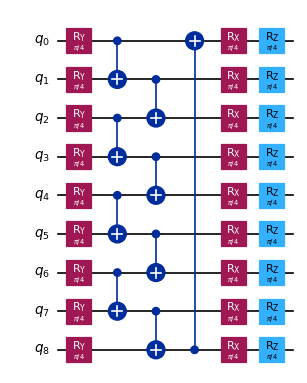

In [2]:
import numpy as np
from qiskit import QuantumCircuit

num_qubits = 9
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
qubits_1 = [i for i in range(num_qubits) if i % 2 == 0]
qubits_2 = [i for i in range(num_qubits) if i % 2 == 1]
qc.cx(qubits_1[:-1], qubits_2)
qc.cx(qubits_2, qubits_1[1:])
qc.cx(qubits_1[-1], qubits_1[0])
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))
qc.draw("mpl", scale=0.6)

In the case where there is no clear way to exploit the structure of a circuit for operator backpropagation, you can partition the circuit into slices of a given depth.

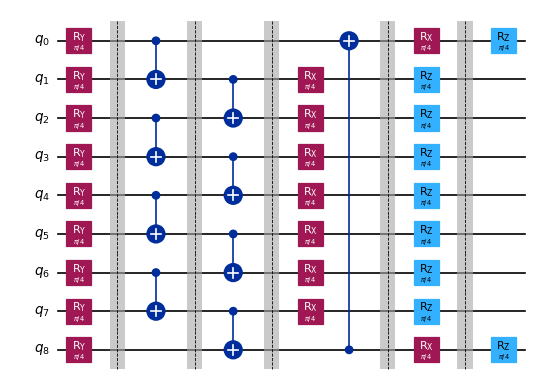

In [3]:
# Slice circuit into partitions of depth 1
slices = slice_by_depth(qc, 1)

# Recombine slices in order to visualize the partitions together
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

In cases such as when executing Trotter circuits to model the dynamics of a quantum system, it may be advantageous to slice by gate type.

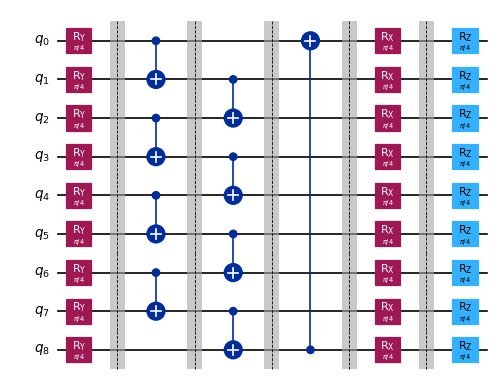

In [4]:
from qiskit_addon_utils.slicing import slice_by_gate_types

slices = slice_by_gate_types(qc)

# Recombine slices in order to visualize the partitions together
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

If your workload is designed to exploit the physical qubit connectivity of the QPU it will be run on, you can create slices based on edge coloring. The code snippet below will assign a three-coloring to circuit edges and slice the circuit with respect to the edge coloring. (Note: this only affects non-local gates. Single-qubit gates will be sliced by gate type).

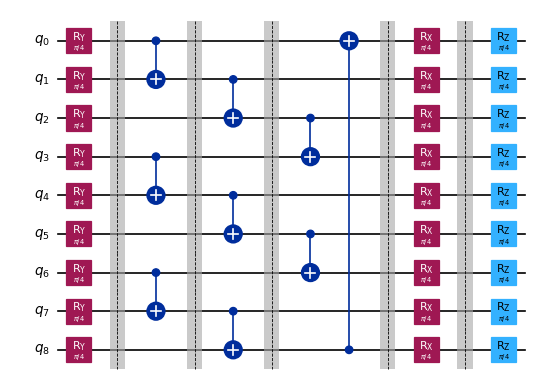

In [5]:
from qiskit_addon_utils.slicing import slice_by_coloring

# Assign a color to each set of connected qubits
coloring = {}
for i in range(num_qubits - 1):
    coloring[(i, i + 1)] = i % 3
coloring[(num_qubits - 1, 0)] = 2

# Create a circuit with operations added in order of color
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
edges = [
    edge for color in range(3) for edge in coloring if coloring[edge] == color
]
for edge in edges:
    qc.cx(edge[0], edge[1])
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))

# Create slices by edge color
slices = slice_by_coloring(qc, coloring=coloring)

# Recombine slices in order to visualize the partitions together
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

If you have a custom slicing strategy, you can instead place barriers in the circuit to delineate where it should be sliced and use the [`slice_by_barriers`](../api/qiskit-addon-utils/slicing#slice_by_barriers) function.

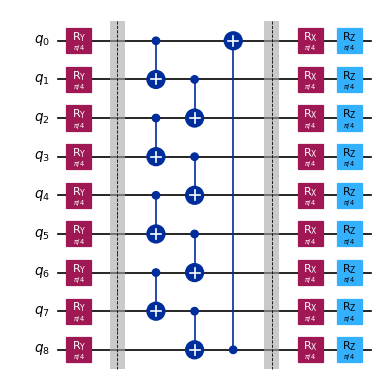

In [6]:
qc = QuantumCircuit(num_qubits)
qc.ry(np.pi / 4, range(num_qubits))
qc.barrier()
qubits_1 = [i for i in range(num_qubits) if i % 2 == 0]
qubits_2 = [i for i in range(num_qubits) if i % 2 == 1]
qc.cx(qubits_1[:-1], qubits_2)
qc.cx(qubits_2, qubits_1[1:])
qc.cx(qubits_1[-1], qubits_1[0])
qc.barrier()
qc.rx(np.pi / 4, range(num_qubits))
qc.rz(np.pi / 4, range(num_qubits))
qc.draw("mpl", scale=0.6)

Once the barriers are in place, you can examine each of the slices individually.

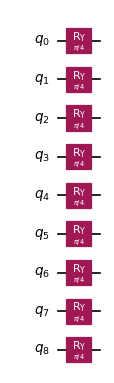

In [7]:
from qiskit_addon_utils.slicing import slice_by_barriers

slices = slice_by_barriers(qc)
slices[0].draw("mpl", scale=0.6)

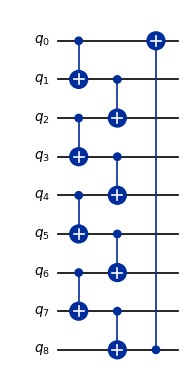

In [8]:
slices[1].draw("mpl", scale=0.6)

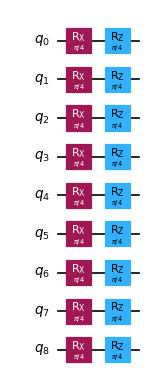

In [9]:
slices[2].draw("mpl", scale=0.6)

## Next steps

<Admonition type="tip" title="Recommendations">
    - Read through the overview of the [OBP addon.](/guides/qiskit-addons-obp)
    - Understand how the [SQD addon](/guides/qiskit-addons-sqd) works.
    - Familiarize yourself with the [AQC-Tensor addon.](/guides/qiskit-addons-aqc)
</Admonition>